In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import datetime
import numerapi

from sklearn import linear_model
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import scipy
import numpy
from scipy import stats

import lightgbm as lgb

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# some API calls do not require logging in
napi = numerapi.NumerAPI(verbosity="info")

In [3]:
# get competitions
all_competitions = napi.get_competitions()
# get leaderboard for the current round
leaderboard = napi.get_leaderboard()
# check if a new round has started
if napi.check_new_round():
    print("new round has started wihtin the last 24hours!")
else:
    print("no new round within the last 24 hours")

2022-04-27 06:16:14,366 INFO numerapi.base_api: getting rounds...
C:\Users\tyrab\AppData\Roaming\Python\Python37\site-packages\cryptography\hazmat\backends\openssl\x509.py:17: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,


no new round within the last 24 hours


In [4]:
# download current dataset
napi.download_current_dataset(unzip=True)

2022-04-27 06:16:21,726 INFO numerapi.utils: starting download
.\numerai_dataset_313.zip: 100%|███████████████████████████████████████████████████▉| 452M/453M [00:48<00:00, 9.67MB/s]2022-04-27 06:17:10,855 INFO numerapi.base_api: unzipping file...
.\numerai_dataset_313.zip: 453MB [01:00, 9.67MB/s]                                                                     

'.\\numerai_dataset_313.zip'

In [5]:
tournament_number = napi.get_current_round()
TOURNAMENT_NAME = "nomi"
TARGET_NAME = "target"
PREDICTION_NAME = "prediction"

In [6]:
training_data = pd.read_csv("./numerai_dataset_"+str(tournament_number)+"/numerai_training_data.csv")
tournament_data = pd.read_csv("./numerai_dataset_"+str(tournament_number)+"/numerai_tournament_data.csv")

In [7]:
training_data['erano'] = training_data.era.str.strip('era').astype('int')

In [8]:
features = [f for f in training_data.columns if 'feature' in f]
target = [f for f in training_data.columns if 'target' in f]

In [12]:
training_data.describe()

,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,...,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target,erano
count,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,...,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000
mean,0.499981,0.499979,0.499979,0.499981,0.499977,0.499977,0.499977,0.499981,0.499980,0.499980,...,0.499982,0.499974,0.499980,0.499982,0.499980,0.499974,0.499979,0.499971,0.499997,64.001987
std,0.353596,0.353593,0.353593,0.353596,0.353587,0.353587,0.353587,0.353596,0.352099,0.352099,...,0.353139,0.351328,0.350662,0.352151,0.352965,0.351328,0.347689,0.353419,0.223268,33.332945
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,...,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.500000,37.000000
50%,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,64.000000
75%,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,...,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.500000,93.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,120.000000


array([[<AxesSubplot:title={'center':'feature_intelligence1'}>,
        <AxesSubplot:title={'center':'target'}>]], dtype=object)

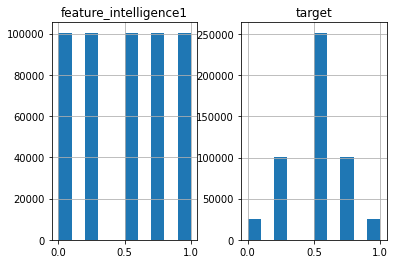

In [14]:
training_data[['feature_intelligence1', 'target']].hist()

In [15]:
clf = lgb.LGBMRegressor(n_estimators = 100, learning_rate = 0.05, objective='mse', metric='None')
clf.fit(training_data[features], training_data[target])

# , eval_set = [(X_test, Y_test)], eval_metric=correlation_score, early_stopping_rounds = 500, verbose=0

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              metric='None', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective='mse', random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [ ]:

def hyperopt_train_test(params):
    
    clf = lgb.LGBMRegressor(**params, objective='mse', metric='None')   
    clf.fit(X_train[features], np.ravel(Y_train), eval_set = [(X_test, Y_test)], eval_metric=correlation_score, early_stopping_rounds = 500, verbose=0)
    preds = clf.predict(X_test[features])
    act = Y_test
    spear_corr = stats.spearmanr(act, preds)[0]
    
    loss = -1.0*spear_corr
    
    return loss

space = {'n_estimators': hp.choice('n_estimators', range(50,10000)),
          'max_depth': hp.choice('max_depth', range(1,10)),
          'colsample_bytree':hp.quniform('colsample_bytree', 0.005, 0.5, 0.005),
          'learning_rate': hp.quniform('learning_rate', 0.005, 0.5, 0.005),
          'subsample': hp.quniform('subsample', 0.05, 0.95, 0.01)}

def f(params):
    loss = hyperopt_train_test(params)
    return {'loss': loss, 'status': STATUS_OK}

trials = Trials()